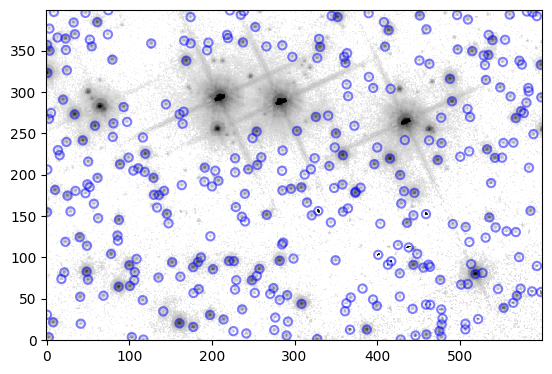

In [21]:
''' carried over from L2_photutils-detection.ipynb '''

# open fits file and extract data
from astropy.io import fits
fits_file = fits.open('ngc1261.fits')
image_data = fits_file[0].data
# define section1 (the portion of the image that we will work with)
section1 = image_data[2250:2650, 5350:5950]
#find mean, median, and standard deviation
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(section1,sigma=3.0)
# detect stars
from photutils.detection import DAOStarFinder
# find stars that have a full-width-half-maximum of about 3 pixels and
# are at least 5 sigma above the background level
daofind = DAOStarFinder(fwhm = 3.0, threshold = 5.0*std)
# display data with matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture
mask = np.zeros(section1.shape, dtype=bool)
# select regions to mask (y:y,x:x)
mask[260:320,40:80] = True
mask[230:350,170:240] = True
mask[260:340,240:320] = True
mask[250:330,420:470] = True
# define sources table
sources = daofind(section1-median,mask=mask)
xpix = sources['xcentroid']
ypix = sources['ycentroid']
# plot new table
positions = np.transpose((xpix,ypix))
apertures = CircularAperture(positions,r=5.0)
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin = 'lower', interpolation='nearest')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);


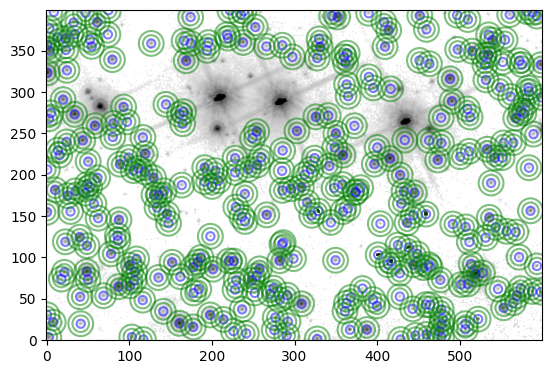

In [22]:
# variable "section1" contains our image data
# variable "positions" contains our positions
# variable "apertures" contains our aperture data

'''find background values by drawing an annulus around each star'''

# import tools
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

# define annuluses
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

# plot annuluses
plt.figure()
plt.imshow(section1, cmap='Greys', norm = LogNorm(), origin = 'lower')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);
annulus_aperture.plot(color='green',lw=1.5,alpha=0.5);
plt.show()

In [23]:
# define background
aperstats = ApertureStats(section1, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aperture_area

# perform aperture photometry
star_data = aperture_photometry(section1, apertures)

# add backgrounds to table
star_data['total_bkg'] = total_bkg

# format and print data
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
display(star_data)

id,xcenter,ycenter,aperture_sum,total_bkg
,pix,pix,,
int32,float64,float64,float64,float64
1,117.19841,0.33785036,967.29562,411.21136
2,428.43611,0.35907893,1134.1804,-105.48141
3,327.47384,1.0581984,5942.7364,-11.126172
4,2.7816756,3.1995047,6895.5637,50.169515
5,103.18459,3.4357617,3531.7091,-37.972177
6,477.75663,3.6764751,2785.9139,617.26379
7,290.51092,5.254984,3165.6819,-7.0288552
8,446.31111,5.2372901,6604.7038,2217.7566


In [24]:
'''
Find zeropoint from catalogue based on filter and instrument.
Install acs tools by typing the following command into the terminal:

    >> pip install acstools
'''

from acstools import acszpt

# find date in header (>> more 'ngc1261.fits')
date = '2018-07-20'

# find intrument in header (>> more 'ngc1261.fits')
detector = 'WFC'

# fetch zeropoint from catalogue
q = acszpt.Query(date = date, detector = detector)
zpt_table = q.fetch()
q_filter = acszpt.Query(date = date, detector = detector, filt = 'F814W')
filter_zpt = q_filter.fetch()

# print data
print(filter_zpt)

Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom cm2 electron) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F814W   8045.5                    7.1014e-20  26.772  25.505  25.936


In [25]:
''' 
Enter zeropoint and exposure time (exposure time found in header), and use them to
calculate magnitudes. To calculate magnitudes, use the equation:

    MAGNITUDE = ZEROPOINT - 2.5*log_10{APERTURE_SUM - TOTAL_BKG}
'''

# use ABmag from filter_zpt
zeropoint = 25.936

# find exposure time in header (>> more 'ngc1261.fits')
extime = 1800

# calculate magnitudes
import math
magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint - (2.5*math.log10(abs(line[3]-line[4]))))

# add magnitudes to table and print data
star_data['magnitude'] = magnitudes
display(star_data)

id,xcenter,ycenter,aperture_sum,total_bkg,magnitude
,pix,pix,,,
int32,float64,float64,float64,float64,float64
1,117.19841,0.33785036,967.29562,411.21136,19.07314850156184
2,428.43611,0.35907893,1134.1804,-105.48141,18.202741941348503
3,327.47384,1.0581984,5942.7364,-11.126172,16.499002991917923
4,2.7816756,3.1995047,6895.5637,50.169515,16.34750384488642
5,103.18459,3.4357617,3531.7091,-37.972177,17.054426398813803
6,477.75663,3.6764751,2785.9139,617.26379,17.595526282309528
7,290.51092,5.254984,3165.6819,-7.0288552,17.18242379602863
8,446.31111,5.2372901,6604.7038,2217.7566,16.830593972868808


In [26]:
''' display entire dataset with pprint '''

star_data.pprint(max_lines = -1, max_width = -1)
    
    

 id  xcenter    ycenter   aperture_sum  total_bkg      magnitude     
       pix        pix                                                
--- ---------- ---------- ------------ ----------- ------------------
  1  117.19841 0.33785036    967.29562   411.21136  19.07314850156184
  2  428.43611 0.35907893    1134.1804  -105.48141 18.202741941348503
  3  327.47384  1.0581984    5942.7364  -11.126172 16.499002991917923
  4  2.7816756  3.1995047    6895.5637   50.169515  16.34750384488642
  5  103.18459  3.4357617    3531.7091  -37.972177 17.054426398813803
  6  477.75663  3.6764751    2785.9139   617.26379 17.595526282309528
  7  290.51092   5.254984    3165.6819  -7.0288552  17.18242379602863
  8  446.31111  5.2372901    6604.7038   2217.7566 16.830593972868808
  9  459.61981  6.5305425    8881.3539   2361.9695  16.40048352423087
 10  241.67749  7.7623865    706.04205  -387.24493  18.33916455964808
 11   226.1103  10.548382    180.47829  -241.71508 19.372221492188416
 12   475.2584  10.6